# Code to simulate the rate of false positives under the null hypothesis.

## Gatekeeping Testing Scheme with Dynamic Alpha Adjustment

This notebook simulates a **gatekeeping testing scheme** involving two primary hypotheses (**$H_a$**, **$H_b$**) and two secondary hypotheses (**$H_c$**, **$H_d$**).

### Stage 1

- Test primary hypothesis $H_a$ at significance level $\alpha_a$.
- Test primary hypothesis $H_b$ at significance level $\alpha_b$.

### Stage 2 (Gatekeeping)

- Test secondary hypothesis $H_c$ **only if** hypothesis $H_a$ is rejected.
- Test secondary hypothesis $H_d$ **only if** hypothesis $H_b$ is rejected.

### Simulating Under the Global Null

Under the **global null hypothesis** (all hypotheses are truly null), p-values are uniformly distributed:

$$
p \sim \text{Uniform}(0, 1)
$$

We allow correlations within each pair of hypotheses:

- Stage-1 hypotheses ($H_a$, $H_b$): correlation $\rho_1$
- Stage-2 hypotheses ($H_c$, $H_d$): correlation $\rho_2$

These correlations are implemented using a **Gaussian copula** approach:

1. Simulate bivariate normal distributions for pairs $(H_a, H_b)$ and $(H_c, H_d)$:

$$
(Z_a, Z_b) \sim N\left(\begin{pmatrix}0 \\ 0\end{pmatrix}, 
\begin{pmatrix}1 & \rho_1 \\ \rho_1 & 1\end{pmatrix}\right), \quad
(Z_c, Z_d) \sim N\left(\begin{pmatrix}0 \\ 0\end{pmatrix}, 
\begin{pmatrix}1 & \rho_2 \\ \rho_2 & 1\end{pmatrix}\right)
$$

2. Transform these normal samples using the standard normal cumulative distribution function ($\Phi$) to obtain correlated uniform p-values:

$$
p_a = \Phi(Z_a), \quad p_b = \Phi(Z_b), \quad p_c = \Phi(Z_c), \quad p_d = \Phi(Z_d)
$$

### Gatekeeping Decision Logic

- Reject $H_a$ if $p_a < \frac{\alpha_a}{2}$.
- Reject $H_b$ if $p_b < \frac{\alpha_b}{2}$.

Stage-2 hypotheses ($H_c$, $H_d$) are tested conditionally based on stage-1 results. The alpha thresholds for stage-2 depend dynamically on stage-1 rejections:

- If **exactly one** primary hypothesis is rejected, the corresponding secondary hypothesis is tested at $\alpha / 4$:

$$
\frac{\alpha_c}{4} \quad\text{or}\quad \frac{\alpha_d}{4}
$$

- If **both** primary hypotheses are rejected, each secondary hypothesis is tested at $\alpha / 2$:

$$
\frac{\alpha_c}{2} \quad\text{and}\quad \frac{\alpha_d}{2}
$$

- If **neither** primary hypothesis is rejected, stage-2 hypotheses **are not tested**.

## Metrics Computed by the Simulation

The simulation returns:

- **Overall Family-Wise Error Rate (FWER)**: Probability of at least one false rejection among $H_a$, $H_b$, $H_c$, $H_d$.
- **Stage-1 error rate**: Probability of rejecting at least one of the primary hypotheses ($H_a$, $H_b$).
- **Stage-2 error rate**: Probability of at least one false rejection among secondary hypotheses ($H_c$, $H_d$).
- **Proportion stage-2 tested**: Frequency of simulations where stage-2 hypotheses are tested (i.e., at least one primary hypothesis rejected).
- **Conditional stage-2 error rate**: Probability of a false rejection in stage-2 hypotheses **given that stage-2 was tested**.

In [37]:
import numpy as np
from scipy.stats import norm

def simulate_fwer_gatekeeping_dynamic_alpha_return_stages(n_sims=1_000_000,
                                                          alpha_a=0.05, alpha_b=0.05,
                                                          alpha_c=0.05, alpha_d=0.05,
                                                          rho_1=0.0, rho_2=0.0,
                                                          seed=None):
    """
    Simulate a gatekeeping testing scheme with two primary hypotheses (Ha, Hb)
    and two secondary hypotheses (Hc, Hd). The alpha levels for the secondary 
    tests depend on how many primary hypotheses were rejected.

    This version returns:
        1) Overall FWER: proportion with at least one false rejection {Ha,Hb,Hc,Hd}
        2) Stage-1 error rate: proportion with at least one false rejection in {Ha,Hb}
        3) Stage-2 error rate: proportion with at least one false rejection in {Hc,Hd}
        4) Proportion of simulations in which Stage-2 is tested at all
        5) Proportion of simulations in which Stage-2 is tested AND at least one false 
           rejection in {Hc,Hd} occurs (i.e., conditional stage-2 error rate)
    
    Parameters
    ----------
    n_sims : int
        Number of simulation iterations.
    alpha_a, alpha_b, alpha_c, alpha_d : float
        Significance levels for each stage (not the per-comparison significance level).
    rho_1 : float
        Correlation between (Ha, Hb).
    rho_2 : float
        Correlation between (Hc, Hd).
    seed : int or None
        Random seed for reproducibility.

    Returns
    -------
    fwer_estimate : float
        Estimated Family-Wise Error Rate (FWER): proportion of simulations with 
        at least one false rejection in {Ha, Hb, Hc, Hd}.
    stage1_error_rate : float
        Proportion of simulations where at least one of (Ha, Hb) is rejected.
    stage2_error_rate : float
        Proportion of simulations where at least one of (Hc, Hd) is rejected.
    stage2_tested_proportion : float
        Proportion of simulations in which stage-2 was tested at all 
        (i.e., Ha or Hb was rejected).
    stage2_error_given_tested : float
        Among simulations where stage-2 is tested, the proportion 
        in which a false rejection in stage-2 (Hc or Hd) occurs.
    """
    if seed is not None:
        np.random.seed(seed)
    
    # (1) Simulate p-values for (Ha, Hb) using a Gaussian copula
    mean_1 = [0.0, 0.0]
    cov_1 = [[1.0,  rho_1],
             [rho_1, 1.0]]
    z_1 = np.random.multivariate_normal(mean_1, cov_1, size=n_sims)
    p_a = norm.cdf(z_1[:, 0])
    p_b = norm.cdf(z_1[:, 1])
    
    # (2) Simulate p-values for (Hc, Hd) using a Gaussian copula
    mean_2 = [0.0, 0.0]
    cov_2 = [[1.0,  rho_2],
             [rho_2, 1.0]]
    z_2 = np.random.multivariate_normal(mean_2, cov_2, size=n_sims)
    p_c = norm.cdf(z_2[:, 0])
    p_d = norm.cdf(z_2[:, 1])
    
    # (3) Stage-1 rejections
    reject_a = (p_a < alpha_a / 2.0)
    reject_b = (p_b < alpha_b / 2.0)
    num_rejected_stage1 = reject_a.astype(int) + reject_b.astype(int)
    
    # (4) Determine dynamic alpha for Hc, Hd
    alpha_c_adj = np.zeros(n_sims, dtype=float)
    alpha_d_adj = np.zeros(n_sims, dtype=float)
    
    # Exactly 1 of (Ha,Hb) rejected => alpha/4 for that single secondary test
    one_rejected_mask = (num_rejected_stage1 == 1)
    alpha_c_adj[one_rejected_mask & reject_a] = alpha_c / 4.0
    alpha_d_adj[one_rejected_mask & reject_b] = alpha_d / 4.0
    
    # Both (Ha,Hb) rejected => alpha/2 for each secondary test
    two_rejected_mask = (num_rejected_stage1 == 2)
    alpha_c_adj[two_rejected_mask] = alpha_c / 2.0
    alpha_d_adj[two_rejected_mask] = alpha_d / 2.0
    
    # (5) Stage-2 rejections (gatekeeping: must have rejected Ha/Hb to test Hc/Hd)
    reject_c = reject_a & (p_c < alpha_c_adj)
    reject_d = reject_b & (p_d < alpha_d_adj)
    
    # (6) Metrics
    #     - Stage-1 error rate: at least one of (Ha, Hb) is rejected
    #     - Stage-2 error rate: at least one of (Hc, Hd) is rejected
    #     - Overall FWER: at least one of (Ha, Hb, Hc, Hd) is rejected
    stage1_any = reject_a | reject_b
    stage2_any = reject_c | reject_d
    any_reject = stage1_any | stage2_any  # FWER
    
    stage1_error_rate = np.mean(stage1_any)
    stage2_error_rate = np.mean(stage2_any)
    fwer_estimate = np.mean(any_reject)
    
    # Stage-2 is tested if Ha or Hb was rejected
    stage2_tested_any = stage1_any  # same as (reject_a | reject_b)
    stage2_tested_proportion = np.mean(stage2_tested_any)
    
    # Among simulations where stage-2 was tested, how often do we get a stage-2 rejection?
    # We'll use conditional probability: 
    #   P(stage2_any | stage2_tested_any) = 
    #     mean(stage2_any & stage2_tested_any) / mean(stage2_tested_any)
    stage2_error_given_tested = 0.0
    if stage2_tested_proportion > 0:  # prevent divide-by-zero
        stage2_error_given_tested = (
            np.mean(stage2_any & stage2_tested_any) / stage2_tested_proportion
        )
    
    return (fwer_estimate,
            stage1_error_rate,
            stage2_error_rate,
            stage2_tested_proportion,
            stage2_error_given_tested)


if __name__ == "__main__":
    # Example usage
    n_sims = 1_000_000
    (fwer, 
     rate_stage1, 
     rate_stage2, 
     prop_stage2_tested, 
     prop_stage2_error_given_tested
    ) = simulate_fwer_gatekeeping_dynamic_alpha_return_stages(
        n_sims=n_sims,
        alpha_a=0.05, alpha_b=0.05,
        alpha_c=0.05,  alpha_d=0.05,
        rho_1=0.0, rho_2=0.0,
        seed=42
    )
    
    print(f"For n_sims={n_sims} under the global null:")
    print(f"  FWER (any of Ha,Hb,Hc,Hd rejected): {fwer:.4f}")
    print(f"  Stage-1 error rate (any of Ha,Hb):   {rate_stage1:.4f}")
    print(f"  Stage-2 error rate (any of Hc,Hd):   {rate_stage2:.4f}")
    print(f"  Stage-2 tested proportion:           {prop_stage2_tested:.4f}")
    print(f"  Stage-2 error (given tested):        {prop_stage2_error_given_tested:.4f}")

For n_sims=1000000 under the global null:
  FWER (any of Ha,Hb,Hc,Hd rejected): 0.0495
  Stage-1 error rate (any of Ha,Hb):   0.0495
  Stage-2 error rate (any of Hc,Hd):   0.0006
  Stage-2 tested proportion:           0.0495
  Stage-2 error (given tested):        0.0127


Note: the reason why the Stage-1 error rate and the FWER are the same is that under the global null (all hypothesis are null), for stage 2 to occur an error must have already happened in stage 1

## A version with the new, proposed stage 2 critical p-values

For this version, stage 1 is the same: 

- Reject $H_a$ if $p_a < \frac{\alpha_a}{2}$.
- Reject $H_b$ if $p_b < \frac{\alpha_b}{2}$.

And Stage-2 hypotheses ($H_c$, $H_d$) are still tested conditionally based on stage-1 results. However, per-comparison alpha thresholds for stage-2 depend differently on stage-1 rejections:

- If **exactly one** primary hypothesis is rejected, the corresponding secondary hypothesis is tested at $\alpha / 1$ (because there is 1 chance to get a spurious positive):

$$
\frac{\alpha_c}{1} \quad\text{or}\quad \frac{\alpha_d}{1}
$$

- If **both** primary hypotheses are rejected, each secondary hypothesis is tested at $\alpha / 2$ (because there are 2 chances to get a spurious positive):

$$
\frac{\alpha_c}{2} \quad\text{and}\quad \frac{\alpha_d}{2}
$$

- If **neither** primary hypothesis is rejected, stage-2 hypotheses **are not tested**.

In [38]:
import numpy as np
from scipy.stats import norm

def new_simulate_fwer_gatekeeping_dynamic_alpha_return_stages(n_sims=1_000_000,
                                                          alpha_a=0.05, alpha_b=0.05,
                                                          alpha_c=0.05, alpha_d=0.05,
                                                          rho_1=0.0, rho_2=0.0,
                                                          seed=None):
    """
    Simulate a gatekeeping testing scheme with two primary hypotheses (Ha, Hb)
    and two secondary hypotheses (Hc, Hd). The alpha levels for the secondary 
    tests depend on how many primary hypotheses were rejected.

    This version returns:
        1) Overall FWER: proportion with at least one false rejection {Ha,Hb,Hc,Hd}
        2) Stage-1 error rate: proportion with at least one false rejection in {Ha,Hb}
        3) Stage-2 error rate: proportion with at least one false rejection in {Hc,Hd}
        4) Proportion of simulations in which Stage-2 is tested at all
        5) Proportion of simulations in which Stage-2 is tested AND at least one false 
           rejection in {Hc,Hd} occurs (i.e., conditional stage-2 error rate)
    
    Parameters
    ----------
    n_sims : int
        Number of simulation iterations.
    alpha_a, alpha_b, alpha_c, alpha_d : float
        Significance levels for each hypothesis.
    rho_1 : float
        Correlation between (Ha, Hb).
    rho_2 : float
        Correlation between (Hc, Hd).
    seed : int or None
        Random seed for reproducibility.

    Returns
    -------
    fwer_estimate : float
        Estimated Family-Wise Error Rate (FWER): proportion of simulations with 
        at least one false rejection in {Ha, Hb, Hc, Hd}.
    stage1_error_rate : float
        Proportion of simulations where at least one of (Ha, Hb) is rejected.
    stage2_error_rate : float
        Proportion of simulations where at least one of (Hc, Hd) is rejected.
    stage2_tested_proportion : float
        Proportion of simulations in which stage-2 was tested at all 
        (i.e., Ha or Hb was rejected).
    stage2_error_given_tested : float
        Among simulations where stage-2 is tested, the proportion 
        in which a false rejection in stage-2 (Hc or Hd) occurs.
    """
    if seed is not None:
        np.random.seed(seed)
    
    # (1) Simulate p-values for (Ha, Hb) using a Gaussian copula
    mean_1 = [0.0, 0.0]
    cov_1 = [[1.0,  rho_1],
             [rho_1, 1.0]]
    z_1 = np.random.multivariate_normal(mean_1, cov_1, size=n_sims)
    p_a = norm.cdf(z_1[:, 0])
    p_b = norm.cdf(z_1[:, 1])
    
    # (2) Simulate p-values for (Hc, Hd) using a Gaussian copula
    mean_2 = [0.0, 0.0]
    cov_2 = [[1.0,  rho_2],
             [rho_2, 1.0]]
    z_2 = np.random.multivariate_normal(mean_2, cov_2, size=n_sims)
    p_c = norm.cdf(z_2[:, 0])
    p_d = norm.cdf(z_2[:, 1])
    
    # (3) Stage-1 rejections
    reject_a = (p_a < alpha_a / 2.0)
    reject_b = (p_b < alpha_b / 2.0)
    num_rejected_stage1 = reject_a.astype(int) + reject_b.astype(int)
    
    # (4) Determine dynamic alpha for Hc, Hd
    alpha_c_adj = np.zeros(n_sims, dtype=float)
    alpha_d_adj = np.zeros(n_sims, dtype=float)
    
    # Exactly 1 of (Ha,Hb) rejected => alpha/4 for that single secondary test
    one_rejected_mask = (num_rejected_stage1 == 1)
    alpha_c_adj[one_rejected_mask & reject_a] = alpha_c # no divide by 4
    alpha_d_adj[one_rejected_mask & reject_b] = alpha_d # no divide by 4
    
    # Both (Ha,Hb) rejected => alpha/2 for each secondary test
    two_rejected_mask = (num_rejected_stage1 == 2)
    alpha_c_adj[two_rejected_mask] = alpha_c / 2.0
    alpha_d_adj[two_rejected_mask] = alpha_d / 2.0
    
    # (5) Stage-2 rejections (gatekeeping: must have rejected Ha/Hb to test Hc/Hd)
    reject_c = reject_a & (p_c < alpha_c_adj)
    reject_d = reject_b & (p_d < alpha_d_adj)
    
    # (6) Metrics
    #     - Stage-1 error rate: at least one of (Ha, Hb) is rejected
    #     - Stage-2 error rate: at least one of (Hc, Hd) is rejected
    #     - Overall FWER: at least one of (Ha, Hb, Hc, Hd) is rejected
    stage1_any = reject_a | reject_b
    stage2_any = reject_c | reject_d
    any_reject = stage1_any | stage2_any  # FWER
    
    stage1_error_rate = np.mean(stage1_any)
    stage2_error_rate = np.mean(stage2_any)
    fwer_estimate = np.mean(any_reject)
    
    # Stage-2 is tested if Ha or Hb was rejected
    stage2_tested_any = stage1_any  # same as (reject_a | reject_b)
    stage2_tested_proportion = np.mean(stage2_tested_any)
    
    # Among simulations where stage-2 was tested, how often do we get a stage-2 rejection?
    # We'll use conditional probability: 
    #   P(stage2_any | stage2_tested_any) = 
    #     mean(stage2_any & stage2_tested_any) / mean(stage2_tested_any)
    stage2_error_given_tested = 0.0
    if stage2_tested_proportion > 0:  # prevent divide-by-zero
        stage2_error_given_tested = (
            np.mean(stage2_any & stage2_tested_any) / stage2_tested_proportion
        )
    
    return (fwer_estimate,
            stage1_error_rate,
            stage2_error_rate,
            stage2_tested_proportion,
            stage2_error_given_tested)


if __name__ == "__main__":
    # Example usage
    n_sims = 1_000_000
    (fwer, 
     rate_stage1, 
     rate_stage2, 
     prop_stage2_tested, 
     prop_stage2_error_given_tested
    ) = new_simulate_fwer_gatekeeping_dynamic_alpha_return_stages(
        n_sims=n_sims,
        alpha_a=0.05, alpha_b=0.05,
        alpha_c=0.05,  alpha_d=0.05,
        rho_1=0.0, rho_2=0.0,
        seed=42
    )
    
    print(f"For n_sims={n_sims} under the global null:")
    print(f"  FWER (any of Ha,Hb,Hc,Hd rejected): {fwer:.4f}")
    print(f"  Stage-1 error rate (any of Ha,Hb):   {rate_stage1:.4f}")
    print(f"  Stage-2 error rate (any of Hc,Hd):   {rate_stage2:.4f}")
    print(f"  Stage-2 tested proportion:           {prop_stage2_tested:.4f}")
    print(f"  Stage-2 error (given tested):        {prop_stage2_error_given_tested:.4f}")

For n_sims=1000000 under the global null:
  FWER (any of Ha,Hb,Hc,Hd rejected): 0.0495
  Stage-1 error rate (any of Ha,Hb):   0.0495
  Stage-2 error rate (any of Hc,Hd):   0.0025
  Stage-2 tested proportion:           0.0495
  Stage-2 error (given tested):        0.0496


## How does the FWER change if the within-stage p-values are correlated?

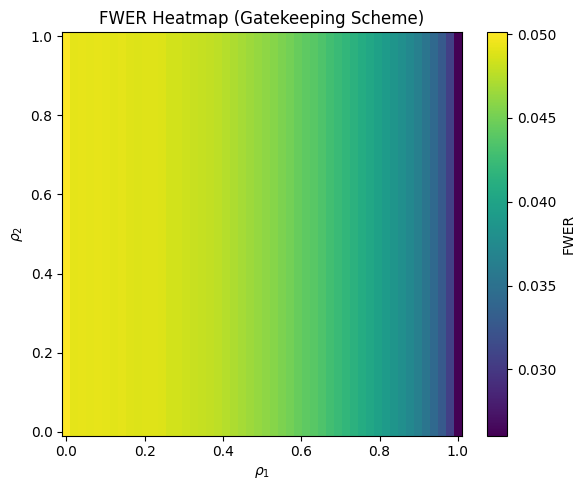

In [40]:
import matplotlib.pyplot as plt

def fwer_heatmap(n_sims=1_000_000,
                 alpha_a=0.025, alpha_b=0.025,
                 alpha_c=0.05, alpha_d=0.05,
                 grid_steps=6, # e.g. 6 steps => [0, 0.2, 0.4, 0.6, 0.8, 1.0]
                 seed=42):
    """
    Vary rho_1 and rho_2 from 0 to 1 in 'grid_steps' even increments.
    Compute FWER at each (rho_1, rho_2) pair, then plot a heatmap.
    
    Parameters
    ----------
    n_sims : int
        Number of simulation iterations per grid point.
    alpha_a, alpha_b, alpha_c, alpha_d : float
        Significance levels for each hypothesis.
    grid_steps : int
        Number of points in the [0,1] range for rho_1 and rho_2.
    seed : int or None
        Random seed for reproducibility.
    """
    # Create an array of rho values from 0 to 1
    rho_values = np.linspace(0, 1, grid_steps)
    
    # Initialize matrix to store the FWER results
    results = np.zeros((grid_steps, grid_steps))
    
    # For reproducibility, we can vary the seed slightly for each iteration
    # or re-use the same seed if we want identical draws. We'll keep it simple
    # and just fix the seed for each call here, which means each grid point
    # will get the same random sequence if we do not vary the seed.
    
    # Double loop over rho_1 (x) and rho_2 (y)
    for i, r1 in enumerate(rho_values):
        for j, r2 in enumerate(rho_values):
            (fwer, 
                rate_stage1, 
                rate_stage2, 
                prop_stage2_tested, 
                prop_stage2_error_given_tested
            ) = new_simulate_fwer_gatekeeping_dynamic_alpha_return_stages(
                n_sims=n_sims,
                alpha_a=alpha_a, alpha_b=alpha_b,
                alpha_c=alpha_c, alpha_d=alpha_d,
                rho_1=r1, rho_2=r2,
                seed=seed
            )
            results[j, i] = fwer  # j => row (y-axis), i => column (x-axis)

    # Plot as a heatmap using pcolormesh or imshow.
    fig, ax = plt.subplots(figsize=(6, 5))
    
    # Construct a grid for plotting (pcolormesh expects X, Y of same shape as 'results')
    X, Y = np.meshgrid(rho_values, rho_values)
    
    # Create the heatmap
    c = ax.pcolormesh(X, Y, results, shading='auto', cmap='viridis')
    
    # Add colorbar
    fig.colorbar(c, ax=ax, label='FWER')
    
    # Set axis labels and title
    ax.set_xlabel(r'$\rho_1$')
    ax.set_ylabel(r'$\rho_2$')
    ax.set_title('FWER Heatmap (Gatekeeping Scheme)')
    
    # Show the plot
    plt.tight_layout()
    plt.show()


# Example usage: 
# You can test with fewer grid_steps or fewer n_sims to confirm it works quickly.
fwer_heatmap(
        n_sims=100_000,        # For a quicker demo, reduce to 100k
        alpha_a=0.05, alpha_b=0.05,
        alpha_c=0.05, alpha_d=0.05,
        grid_steps=50,          
        seed=42
    )

As you can see, the overall FWER is solely driven by the $\rho_1$ (correlation in stage 1) == no variation by $\rho_2$, because: 

- stage 2 is seldom tested under the global null (only in <5% of cases)
- under the global null, at least one false positive has already happened whenever the stage 2 gate is opened

### How does the rate of type-1 error vary when stage 2 is tested, if there are p-value correlations in stage 1 and/or stage 2?

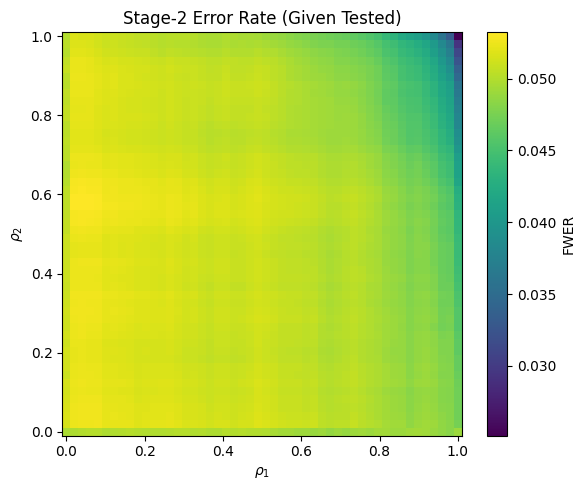

In [48]:
import matplotlib.pyplot as plt

def fwer_heatmap(n_sims=1_000_000,
                 alpha_a=0.05, alpha_b=0.05,
                 alpha_c=0.05, alpha_d=0.05,
                 grid_steps=50, # e.g. 6 steps => [0, 0.2, 0.4, 0.6, 0.8, 1.0]
                 seed=42):
    """
    Vary rho_1 and rho_2 from 0 to 1 in 'grid_steps' even increments.
    Compute FWER at each (rho_1, rho_2) pair, then plot a heatmap.
    
    Parameters
    ----------
    n_sims : int
        Number of simulation iterations per grid point.
    alpha_a, alpha_b, alpha_c, alpha_d : float
        Significance levels for each hypothesis.
    grid_steps : int
        Number of points in the [0,1] range for rho_1 and rho_2.
    seed : int or None
        Random seed for reproducibility.
    """
    # Create an array of rho values from 0 to 1
    rho_values = np.linspace(0, 1, grid_steps)
    
    # Initialize matrix to store the FWER results
    results = np.zeros((grid_steps, grid_steps))
    
    # For reproducibility, we can vary the seed slightly for each iteration
    # or re-use the same seed if we want identical draws. We'll keep it simple
    # and just fix the seed for each call here, which means each grid point
    # will get the same random sequence if we do not vary the seed.
    
    # Double loop over rho_1 (x) and rho_2 (y)
    for i, r1 in enumerate(rho_values):
        for j, r2 in enumerate(rho_values):
            (fwer, 
                rate_stage1, 
                rate_stage2, 
                prop_stage2_tested, 
                prop_stage2_error_given_tested
            ) = new_simulate_fwer_gatekeeping_dynamic_alpha_return_stages(
                n_sims=n_sims,
                alpha_a=alpha_a, alpha_b=alpha_b,
                alpha_c=alpha_c, alpha_d=alpha_d,
                rho_1=r1, rho_2=r2,
                seed=seed
            )
            results[j, i] = prop_stage2_error_given_tested  # j => row (y-axis), i => column (x-axis)

    # Plot as a heatmap using pcolormesh or imshow.
    fig, ax = plt.subplots(figsize=(6, 5))
    
    # Construct a grid for plotting (pcolormesh expects X, Y of same shape as 'results')
    X, Y = np.meshgrid(rho_values, rho_values)
    
    # Create the heatmap
    c = ax.pcolormesh(X, Y, results, shading='auto', cmap='viridis')
    
    # Add colorbar
    fig.colorbar(c, ax=ax, label='FWER')
    
    # Set axis labels and title
    ax.set_xlabel(r'$\rho_1$')
    ax.set_ylabel(r'$\rho_2$')
    ax.set_title('Stage-2 Error Rate (Given Tested)')
    
    # Show the plot
    plt.tight_layout()
    plt.show()


# Example usage: 
# You can test with fewer grid_steps or fewer n_sims to confirm it works quickly.
fwer_heatmap(
        n_sims=1_000_000,        # For a quicker demo, reduce to 50k
        alpha_a=0.05, alpha_b=0.05,
        alpha_c=0.05, alpha_d=0.05,
        grid_steps=50,          
        seed=42
    )

#### Just considering two studies (to build intuition on the influence on a single stage, and the effect of correlation between the tested hypothesis) 

In [ ]:
import numpy as np
from scipy.stats import norm

def simulate_fwer_two_hypotheses(n_sims=10_000_00, alpha=0.05, rho=0.0, seed=None):
    """
    Simulate the family-wise error rate (FWER) for two hypotheses under the null,
    with optional correlation (rho) between the two p-values via a Gaussian copula.
    
    Parameters:
    -----------
    n_sims : int
        Number of simulation iterations.
    alpha : float
        Significance level ***for each test***. 
    rho : float
        Desired correlation in the underlying normal distribution. This induces
        correlation among the simulated p-values.
    seed : int or None
        Random seed for reproducibility.
        
    Returns:
    --------
    fwer_estimate : float
        Estimated FWER = P(Reject at least one hypothesis | global null true).
    """
    if seed is not None:
        np.random.seed(seed)
    
    # Mean and covariance for bivariate normal
    mean = np.array([0.0, 0.0])
    cov = np.array([
        [1.0,    rho],
        [rho,  1.0  ]
    ])
    
    # 1. Generate correlated samples from a bivariate normal
    normal_samples = np.random.multivariate_normal(mean, cov, size=n_sims)
    
    # 2. Transform to uniform(0,1) via the standard normal CDF -> This is a Gaussian copula
    pvals = norm.cdf(normal_samples)
    
    # 3. Check whether either p-value is < alpha
    #    If any is < alpha, that iteration counts as a family-wise "rejection"
    reject_any = np.any(pvals < alpha, axis=1)
    
    # 4. The empirical FWER is the proportion of simulations where at least one test was significant
    fwer_estimate = np.mean(reject_any)
    
    return fwer_estimate

if __name__ == "__main__":
    # Example usage:
    # Simulate with no correlation
    fwer_r0 = simulate_fwer_two_hypotheses(n_sims=10000000, alpha=0.025, rho=0.0, seed=42)
    print(f"FWER estimate with rho=0 (independent tests): {fwer_r0:.4f}")
    
    # Simulate with a positive correlation
    fwer_r5 = simulate_fwer_two_hypotheses(n_sims=10000000, alpha=0.025, rho=0.75, seed=42)
    print(f"FWER estimate with rho=0.5: {fwer_r5:.4f}")

FWER estimate with rho=0 (independent tests): 0.0494
FWER estimate with rho=0.5: 0.0404
